In [1]:
using  Plots
using SymPy
using DifferentialEquations
using LinearAlgebra

9


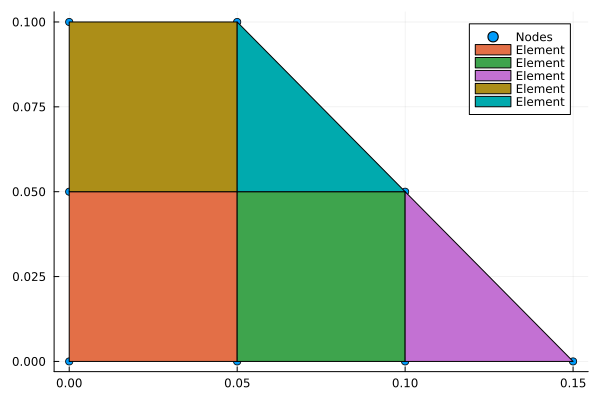

In [2]:
nodes = [
    [0.0, 0.0],
    [0.05, 0.0],
    [0.1, 0.0],
    [0.15, 0.0],
    [0.0, 0.05],
    [0.05, 0.05],
    [0.1, 0.05],
    [0, 0.1],
    [0.05, 0.1]
]

# Define the connectivity of the 4 elements by specifying the node indices for each element
elements = [
    [1, 2, 6, 5],
    [2, 3, 7, 6],
    [3,4,7],
    [5,6,9,8],
    [6,7,9]
]

number_of_nodes = maximum(elements[1])  # Initialize with the maximum value of the first subarray

# Loop through the nested arrays and find the maximum value
for subarray in elements
    max_subarray = maximum(subarray)
    if max_subarray > number_of_nodes
        number_of_nodes = max_subarray
    end
end

println(number_of_nodes)

# Create an empty plot
p = plot(legend=true, markersize=5)

# Plot the nodes
scatter!(p, [p[1] for p in nodes], [p[2] for p in nodes], label="Nodes")

# Plot the elements
for element in elements
    plot!(p, [nodes[i][1] for i in element], [nodes[i][2] for i in element], seriestype=:shape, linecolor=:auto, label="Element")
end

display(p)

In [3]:
#Define shape functions for triangular and quadrilateral elements
e = symbols("e")
n = symbols("n")

T = [symbols("T$i") for i in 1:number_of_nodes]

S1_quad=1/4*(1-e)*(1-n)
S2_quad=1/4*(1+e)*(1-n)
S3_quad=1/4*(1+e)*(1+n)
S4_quad=1/4*(1-e)*(1+n)

Shape_functions_quad=[S1_quad,S2_quad,S3_quad,S4_quad]
dS_de_quads = [diff(S_quad, e) for S_quad in Shape_functions_quad]
dS_dn_quads = [diff(S_quad, n) for S_quad in Shape_functions_quad]

combinations_quad=[]

for shape_function_1 in Shape_functions_quad
    for shape_function_2 in Shape_functions_quad
        push!(combinations_quad, [shape_function_1,shape_function_2])
    end
end

S1_tri=1-e-n
S2_tri=e
S3_tri=n

Shape_functions_tri=[S1_tri,S2_tri,S3_tri]
dS_de_tris = [diff(S_tri, e) for S_tri in Shape_functions_tri]
dS_dn_tris = [diff(S_tri, n) for S_tri in Shape_functions_tri]

combinations_tri=[]

for shape_function_1 in Shape_functions_tri
    for shape_function_2 in Shape_functions_tri
        push!(combinations_tri, [shape_function_1,shape_function_2])
    end
end

In [4]:
stiffness_matrices=[]

for (i,element) in enumerate(elements)
    K=[]
    if length(element)==4
        diff_matrix = [dS_de_quads[1] dS_de_quads[2] dS_de_quads[3] dS_de_quads[4]; 
               dS_dn_quads[1] dS_dn_quads[2] dS_dn_quads[3] dS_dn_quads[4]]
        node_matrix=[nodes[element[1]][1] nodes[element[1]][2];
            nodes[element[2]][1] nodes[element[2]][2];
            nodes[element[3]][1] nodes[element[3]][2];
            nodes[element[4]][1] nodes[element[4]][2]]
        Jacobian=diff_matrix*node_matrix
        d=det(Jacobian)
        J=inv(Jacobian)
        for combination in combinations_quad
            S1,S2=combination
            dS1_de = diff(S1, e)
            dS2_de = diff(S2, e)
            dS1_dn = diff(S1, n)
            dS2_dn = diff(S2, n)
            expression=(((J[1,1]*dS1_de+J[1,2]*dS1_dn)*(J[1,1]*dS2_de+J[1,2]*dS2_dn))+((J[2,1]*dS1_de+J[2,2]*dS1_dn)*(J[2,1]*dS2_de+J[2,2]*dS2_dn)))*1.4*d
            result = integrate(expression, (e, -1, 1), (n, -1, 1)).round(4)
            push!(K,result)
        end
    #K=reshape(K,4,4)
    else
        diff_matrix = [dS_de_tris[1] dS_de_tris[2] dS_de_tris[3] ; 
               dS_dn_tris[1] dS_dn_tris[2] dS_dn_tris[3]]
        node_matrix=[nodes[element[1]][1] nodes[element[1]][2];
            nodes[element[2]][1] nodes[element[2]][2];
            nodes[element[3]][1] nodes[element[3]][2]]
        Jacobian=diff_matrix*node_matrix
        d=det(Jacobian)
        J=inv(Jacobian)
        for combination in combinations_tri
            S1,S2=combination
            dS1_de = diff(S1, e)
            dS2_de = diff(S2, e)
            dS1_dn = diff(S1, n)
            dS2_dn = diff(S2, n)
            expression=(((J[1,1]*dS1_de+J[1,2]*dS1_dn)*(J[1,1]*dS2_de+J[1,2]*dS2_dn))+((J[2,1]*dS1_de+J[2,2]*dS1_dn)*(J[2,1]*dS2_de+J[2,2]*dS2_dn)))*1.4*d
            result = integrate(expression, (n, 0, 1-e), (e, 0, 1)).round(4)
            push!(K,result)
        end
    #K=reshape(K,3,3)
        
    end
    
    push!(stiffness_matrices,K)
end

In [5]:
matrix_location=[]
for element in elements
    location=[]
    for i in element
        for j in element
            push!(location,[i,j])
        end
    end
    push!(matrix_location,location)
end

K_global =zeros(number_of_nodes,number_of_nodes)
for i in 1:number_of_nodes
    for j in 1:number_of_nodes
        for (a,loc) in enumerate(matrix_location)
            for (b,k) in enumerate(loc)
                if [i,j]==k
                    K_global[i,j]+=stiffness_matrices[a][b]
                    K_global[i,j]=round(K_global[i,j],digits=3)
                end
            end
        end
    end
end

show(stdout, "text/plain", K_global)

9×9 Matrix{Float64}:
  0.933  -0.233   0.0     0.0  -0.233  -0.467   0.0     0.0     0.0
 -0.233   1.866  -0.233   0.0  -0.467  -0.466  -0.467   0.0     0.0
  0.0    -0.233   2.333  -0.7   0.0    -0.467  -0.933   0.0     0.0
  0.0     0.0    -0.7     0.7   0.0     0.0     0.0     0.0     0.0
 -0.233  -0.467   0.0     0.0   1.866  -0.466   0.0    -0.233  -0.467
 -0.467  -0.466  -0.467   0.0  -0.466   4.199  -0.933  -0.467  -0.933
  0.0    -0.467  -0.933   0.0   0.0    -0.933   2.333   0.0     0.0
  0.0     0.0     0.0     0.0  -0.233  -0.467   0.0     0.933  -0.233
  0.0     0.0     0.0     0.0  -0.467  -0.933   0.0    -0.233   1.633

In [6]:
h_in=70
t_in=300
h_out=21
t_out=20

B=[]

for (i,element) in enumerate(elements)
    element_B=[]
     if i==1||i==2||i==3
        alpha=-(h_out)
        beta=(h_out*t_out)
        for (a,j) in enumerate(element)
                if a==1
                    r=(0.05/6)*(3*beta+2*alpha*T[j]+alpha*T[element[a+1]])
                    push!(element_B,r)
                elseif a==2
                    r=(0.05/6)*(3*beta+2*alpha*T[j]+alpha*T[element[a-1]])
                    push!(element_B,r)
                else
                    r=0
                    push!(element_B,r)
                end
        end
        push!(B,element_B)
        
    elseif i==4
        alpha=-(h_in)
        beta=(h_in*t_in)
        for(a,j) in enumerate(element)
            if a==4
                r=(0.05/6)*(3*beta+2*alpha*T[j]+alpha*T[element[a-1]])
                push!(element_B,r)
            elseif a==3
                r=(0.05/6)*(3*beta+2*alpha*T[j]+alpha*T[element[a+1]])
                push!(element_B,r)
            else
                r=0
                push!(element_B,r)
            end
        end
        push!(B,element_B)
    
    else i==5
        for(a,j) in enumerate(element)
            r=0
            push!(element_B,r)
        end
        push!(B,element_B)
    
    end
                
end

B_global = Any[0 for _ in 1:number_of_nodes]
for i in 1:number_of_nodes
    for (a,element) in enumerate(elements)
        for (b,ele) in enumerate(element) 
            if i==ele
                B_global[i]+=B[a][b]
            end
        end
    end
end



In [7]:
A=K_global*T

equations = [Eq(A[i], B_global[i]) for i in 1:number_of_nodes]
solutions = solve(equations,T)

for i in 1:number_of_nodes
    variable = T[i]
    solution = solutions[variable]
    value = float(solution)
    println("$variable = $value")
end

T1 = 97.12171570413355
T2 = 88.94663305712328
T3 = 73.22817627130371
T4 = 46.61408813565231
T5 = 163.32572341936572
T6 = 151.80591643335748
T7 = 107.79892247369287
T8 = 263.14712334345666
T9 = 232.4272499075516


sys:1: SymPyDeprecationWarning: 

non-Expr objects in a Matrix is deprecated. Matrix represents
a mathematical matrix. To represent a container of non-numeric
entities, Use a list of lists, TableForm, NumPy array, or some
other data structure instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-non-expr-in-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

